## 2 A Little More on PyMC

### 2.1.1 Parent and Child Relationships

* __Parent variables__ are the variables that influence another variable.
* __Child variables__ are the variables that are affected by other variables - are the subject of parent variables.

A variable can be both a parent and child.

In [1]:
import pymc as pm

lambda_ = pm.Exponential('poisson_param', 1)
# used in the call to the next variable
data_generator = pm.Poisson('data_generator', lambda_)
data_plus_one = data_generator + 1

In [2]:
print('Children of lambda_:\n', lambda_.children)
print('\nParents of data_generator:\n', data_generator.parents)
print('\nChildren of data_generator:\n', data_generator.children)

Children of lambda_:
 {<pymc.distributions.new_dist_class.<locals>.new_class 'data_generator' at 0x00000229C3C5C048>}

Parents of data_generator:
 {'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'poisson_param' at 0x00000229C3C3ECC0>}

Children of data_generator:
 {<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x00000229C3C3ED68>}


### 2.1.2 PyMC Variables

In [3]:
print('lambda_.value =', lambda_.value)
print('data_generator.value =', data_generator.value)
print('data_plus_one.value =', data_plus_one.value)

lambda_.value = 1.544460088798696
data_generator.value = 3
data_plus_one.value = 4


PyMC is concerned with two types of programming variables:

 * __Stochastic variables (random)__ 
 * __Deterministic variables__
 
Note: PyMC [distributions](http://pymc-devs.github.io/pymc/distributions.html).

#### Initializing Stochastic Variables

some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4) - 0 and 4 are lower and upper bound of random variable.

#### Calling random():

We can also call on a stochastic variable's random() method, which (given the parent values) will generate a new, random value. The call to _random_ stores a new value into the variable's _value_ attribute. New value is stored in the computer's cache for faster recall and efficiency.

In [4]:
lambda_1 = pm.Exponential('lambda_1', 1)
lambda_2 = pm.Exponential('lambda_2', 1)
tau = pm.DiscreteUniform('tau', lower=0, upper=10)

print('lambda_1.value = {0:.3f}'.format(lambda_1.value))
print('lambda_2.value = {0:.3f}'.format(lambda_2.value))
print('tau.value = {0:.3f}'.format(tau.value))

lambda_1.random(), lambda_2.random(), tau.random()

print('\nAfter calling random() on the variables:')
print('lambda_1.value = {0:.3f}'.format(lambda_1.value))
print('lambda_2.value = {0:.3f}'.format(lambda_2.value))
print('tau.value = {0:.3f}'.format(tau.value))

lambda_1.value = 0.572
lambda_2.value = 0.063
tau.value = 4.000

After calling random() on the variables:
lambda_1.value = 0.892
lambda_2.value = 0.180
tau.value = 8.000


#### Deterministic Variables

@pm.deterministic  
def some_deterministic_var(v1=v1,):  
&nbsp;&nbsp;&nbsp;&nbsp;code

Elementary operations, like addition, exponentials, and so forth implicitly create deterministic variables.

In [5]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

Inside the deterministic decorator, the __Stochastic__ variables passed in behave like scalars or NumPy arrays (if multivariate), and not like stochastic variables.

@pm.deterministic  
def some_deterministic(stoch=some_stochastic_var):  
&nbsp;&nbsp;&nbsp;&nbsp;return stoch.value**2

This will return AttributeError. It simply needs to be stoch\*\*2 instead of stoch.value

### 2.1.3 Including Observations in the Model

We specified our priors. We can now look at the distribution:

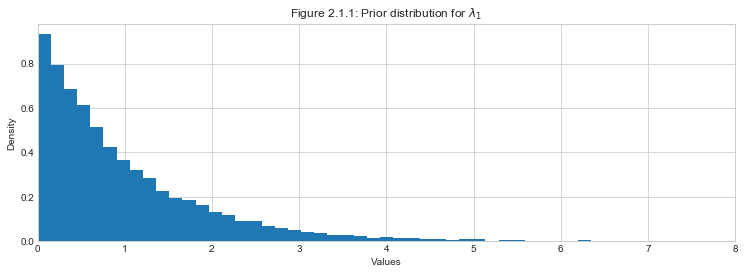

In [6]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
figsize(12.5, 4)

samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype='stepfilled')
plt.title('Figure 2.1.1: Prior distribution for $\lambda_1$')
plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim(0, 8);

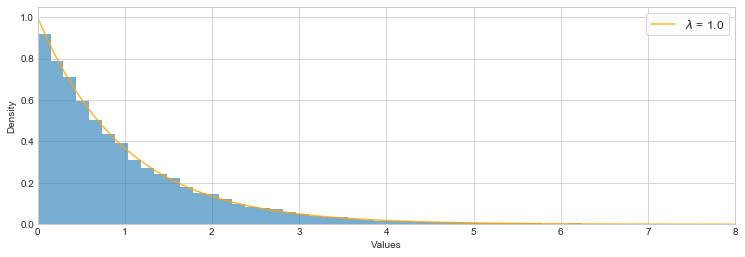

In [7]:
# trying scipy stats module
import numpy as np
from scipy.stats import expon
x = np.linspace(0, 8, 20000)

y_expon = expon.pdf(x, scale = 1.0)
r = expon.rvs(size=20000)

plt.plot(x, y_expon, c='orange', alpha=0.8, label='$\lambda$ = 1.0')
plt.hist(r, bins=70, normed=True, histtype='stepfilled', alpha=0.6)
plt.xlabel('Values')
plt.ylabel('Density')
plt.xlim(0, 8)
plt.legend(loc='upper right', frameon=True, fontsize='12');

PyMC stochastic variables have a keyword argument __observed__ which accepts a boolean (False by default). The keyword observed has a very simple role: fix the variable's current value, i.e. make value immutable.

In [8]:
data = np.array([10, 5])
fixed_variable = pm.Poisson("fxd", 1, value=data, observed=True)
print('value:', fixed_variable.value)
print('calling .random()')
fixed_variable.random()
print('value:', fixed_variable.value)

value: [10  5]
calling .random()
value: [10  5]


### 2.1.4 Finally...

We wrap all created variables into a pm.Model class. 

In [9]:
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)
print(obs.value)

[10 25 15 20 35]


In [10]:
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])

### Modeling Approaches

A good starting thought to Bayesian modeling is to think how the data might have been generated.

### 2.2.1 Same Story, Different Ending

We can create new datasets by retelling the story.

1 - Specify when the user's behavior switches by sampling from DiscreteUniform(0, 80):

In [11]:
# similar to np.random.randint
tau = pm.rdiscrete_uniform(0, 80)
print(tau)

58


2 - Draw $\lambda_1$ and $\lambda_2$ from an $Exp(\alpha)$ distribution:

In [12]:
alpha = 1. / 20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print(lambda_1, lambda_2)

10.519592316092837 0.314559883173564


3 - For days before $\tau$, represent the user's received SMS count by sampling from $Poi(\lambda_1)$, and sample from $Poi(\lambda_2)$ for days after $\tau$:

In [13]:
data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
print(data)

[10 10 15  7 18  8  8 14 14 13 14 13 22 10  7 10 10 15  8 12  6 16 11 12
 17 10 10  7  7 12 10 10 14 12 15  7 13  9 12 10  9 12  7 13  6  6  5 14
 10  8 12  9 15  8  9  8  6 13  0  1  0  0  2  1  0  0  1  0  0  1  1  1
  0  0  0  1  0  0  0  0]


4 - Plot the artificial dataset:

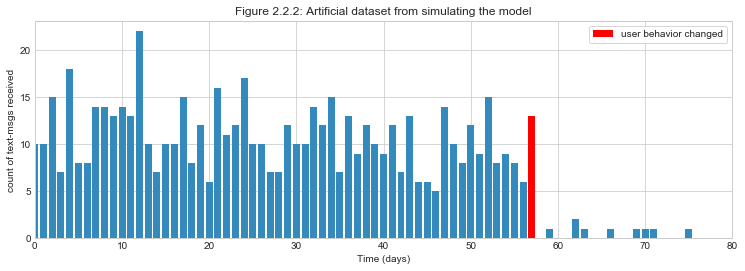

In [14]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau - 1, data[tau - 1], color='r', label='user behavior changed')
plt.xlabel('Time (days)')
plt.ylabel('count of text-msgs received')
plt.title('Figure 2.2.2: Artificial dataset from simulating the model')
plt.xlim(0, 80)
plt.legend(frameon=True);

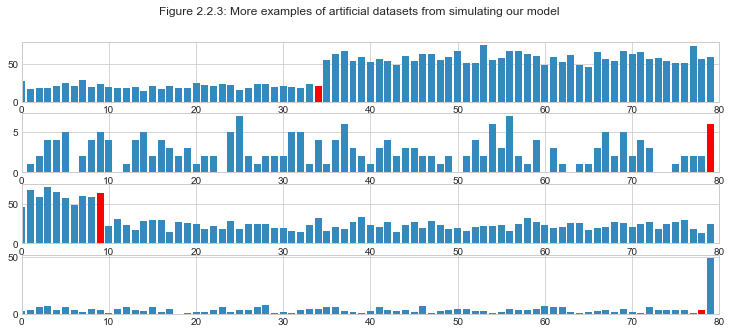

In [15]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1. / 20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau - 1], color='r', label='user behavior changed')
    plt.xlim(0, 80)
    
figsize(12.5, 5)
plt.suptitle('Figure 2.2.3: More examples of artificial datasets from simulating our model')

for i in range(1, 5):
    plt.subplot(4, 1, i)
    plot_artificial_sms_dataset()

### 2.2.2 Example: Bayesian A/B Testing

### 2.2.3 A Simple Case

Assume that there is some probability, $p_A$, that users who are shown site A eventually convert. Observed frequency $\frac{n}{N}$ doesn't necessarily equal $p_A$. We must determine the true frequency of events:

 * The fraction of users who make purchases
 * The frequency of social attributes
 * The percent of Internet users with cats, etc.
 
Often the true frequency is hidden from us and we must infer it from observed data. We are interested in using what we know, $N$ (the total trials administered) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of buyers, might be. To set up a Bayesian model, we need to assign prior distributions to our unknown quantities. Let's assume  $p_A$ is uniform over \[0, 1\]:

In [16]:
p = pm.Uniform('p', lower=0, upper=1)

Suppose $p_A = 0.05$, and $N = 1500$. We will use Bernoulli distribution to simulate N trials:  
If $X \sim Ber(p)$, the X is 1 with probability p, and 0 with probability 1 - p:

In [17]:
# Set constants; p_true is unknown in real life
p_true = 0.05
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
occurrences = pm.rbernoulli(p_true, N)

print(occurrences)
print(occurrences.sum())

[False False False ... False False False]
85


In [18]:
# Checking if observed frequency is equal to true
print('Observed frequency in Group A: {0:.4f}'.format(occurrences.mean()))
print('Observed frequency equal true? {}'.format(occurrences.mean() == p_true))

Observed frequency in Group A: 0.0567
Observed frequency equal true? False


We combine the observations into PyMC observed variable, and run inference algorithm:

In [19]:
# include observations (Bernoulli)
obs = pm.Bernoulli('obs', p, value=occurrences, observed=True)

mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 1.5 sec

Plotting posterior distribution of the unknown $p_A$:

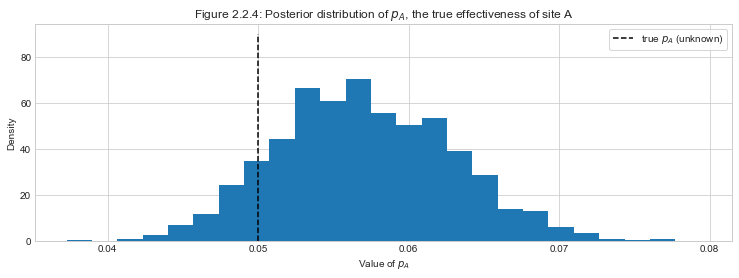

In [20]:
figsize(12.5, 4)
plt.title('Figure 2.2.4: Posterior distribution of $p_A$, the true effectiveness of site A')
plt.hist(mcmc.trace('p')[:], bins=25, histtype='stepfilled', normed=True)
plt.vlines(p_true, 0, 90, linestyle='--', label='true $p_A$ (unknown)')
plt.xlabel('Value of $p_A$')
plt.ylabel('Density')
plt.legend(frameon=True);

p.41